In [1]:
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.losses import BinaryCrossentropy
from keras.metrics import MeanIoU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path
import os
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset 

In [3]:
path=Path('../dataset')
path_train=path/'train'
path_test=path/'test'
path_gt=path/'GT_ICM'
path_model=Path('../models/models')

### Load dataset

In [4]:
dim=(256,256)
def load_imgs(path, path_gt=''):
    files=[path/f for f in os.listdir(path)]
    x = np.array([cv2.resize(cv2.imread(str(f),cv2.IMREAD_GRAYSCALE), dim) for f in files])
    if path_gt == '':
        y=None
    else:
        y = np.array([cv2.threshold(cv2.resize(cv2.imread(str(path_gt/(f.stem+' ICM_Mask.bmp')),cv2.IMREAD_GRAYSCALE), dim),127,255,cv2.THRESH_BINARY)[1] for f in files])
    return x,y

In [5]:
x_train, y_train = load_imgs(path_train, path_gt)
x_test, y_test = load_imgs(path_test, path_gt)

### Standard normalization 

In [6]:
def std_norm(x):
    mean, std= np.mean(x, axis=0), np.std(x, axis=0) 
    return ((x.astype('float32') - mean) / std , mean, std)

def std_norm_test(x,mean,std):
    return (x.astype('float32') - mean) / std

In [7]:
x_train, mean, std = std_norm(x_train)
x_test = std_norm_test(x_test, mean, std)

### Data augmentation

In [8]:
def data_augmentation(x_train, y_train):
    x_train_augmented, y_train_augmented=[], []
    for k in range(len(x_train)):
        img=x_train[k]
        mask=y_train[k]
        for i in range(37):
            x_train_augmented.append(imutils.rotate(img, angle=10*i))
            y_train_augmented.append(imutils.rotate(mask, angle=10*i))
    return np.array(x_train_augmented), np.array(y_train_augmented)

In [9]:
x_train, y_train = data_augmentation(x_train, y_train)

In [10]:
x_train = x_train.astype("float32") 
y_train = y_train.astype("float32")/255  

x_test = x_test.astype("float32") 
y_test = y_test.astype("float32")/255  

### Randomize data

In [11]:
x_train, y_train = shuffle(x_train, y_train, random_state=13)

#### Show train image and its mask

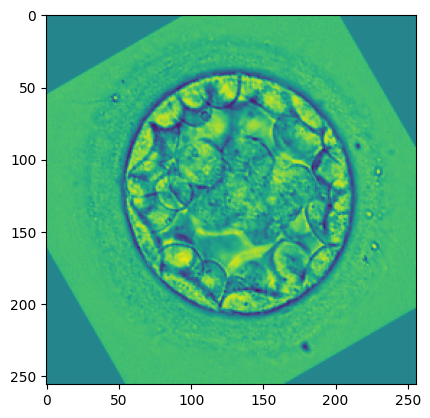

In [12]:
plt.imshow(x_train[0])

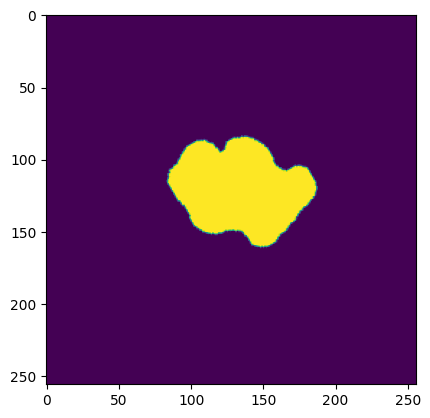

In [13]:
plt.imshow(y_train[0])

# Model

In [14]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", activation='relu')(input)
    x = Dropout(0.05) (x)
    x = Conv2D(num_filters, 3, padding="same", activation='relu')(x)
    x = Dropout(0.05) (x)
    return x

#Encoder block: Conv block followed by maxpooling and residual block

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters) # convolutional block
    x = BatchNormalization()(x)
    input = Conv2D(num_filters, 1, padding="same")(input)
    transfer = tf.math.add(x,input)
    p = MaxPool2D(2)(transfer) #subsampling block  
    p = Activation("relu")(p)
    return x, p  


#Bottleneck block: 4 dilaten convolution layers

def bottleneck_block(input, num_filters):
    x1 = Conv2D(num_filters, 3, dilation_rate=1,  padding="same" )(input)
    x1 =  Dropout(0.05) (x1)
    x2 = Conv2D(num_filters, 3, dilation_rate=2, padding="same" )(x1)
    x2 =  Dropout(0.05) (x2)
    x3 = Conv2D(num_filters, 3, dilation_rate=4, padding="same" )(x2)
    x3 =  Dropout(0.05) (x3)
    x4 = Conv2D(num_filters, 3, dilation_rate=8, padding="same" )(x3)
    x4 =  Dropout(0.05) (x4)
    c = Concatenate(axis=3)([x1, x2, x3, x4])
    x = Conv2D(num_filters, 3, padding="same", activation='relu')(c)
    x = Dropout(0.05) (x)
    return  x


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = UpSampling2D(size=2)(input)
    x = BatchNormalization()(x) 
    x1 = Concatenate(axis=3)([x, skip_features])
      
    x = Conv2D(num_filters, 3, padding="same", activation='relu')(x1)
    x = Dropout(0.05) (x)
    x = Conv2D(num_filters, 3, padding="same", activation='relu')(x)
    x = Dropout(0.05) (x)
    x1 = Conv2D(num_filters, 1, padding="same")(x1)
    return tf.math.add(x,x1)

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1   = bottleneck_block(p4, 128) #Bridge

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  
    model = Model(inputs, outputs, name="U-Net")
    return model

In [15]:
model= build_unet(input_shape=(256,256,1))

### Loss function

In [16]:
def jaccard_index(y_true, y_pred):
    """ Calculates mean of Jaccard index as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection) / (sum_ - intersection)
    return tf.reduce_mean(jac)

def my_loss_fn(y_true, y_pred):
    return BinaryCrossentropy(from_logits=True)(y_true, y_pred)-tf.math.log(jaccard_index(y_true, y_pred))

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    # Loss function to minimize
    loss=my_loss_fn,
    # List of metrics to monitor
    metrics=[jaccard_index])

In [15]:
callbacks = [
    EarlyStopping(patience=15),
    ModelCheckpoint(filepath=path_model/'models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    ReduceLROnPlateau(factor=0.05, patience=5)]

In [16]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y=shuffle(batch_x, batch_y, random_state=1)
        return batch_x, batch_y

### Training

In [21]:
history = model.fit(
    DataGenerator(x_train, y_train, 16),
    batch_size=16,
    epochs=200,
    callbacks=callbacks,
    validation_data=(x_test, y_test))

Epoch 1/200
488/488 [==============================] - 115s 194ms/step - loss: 1.1989 - jaccard_index: 0.6399 - val_loss: 1.1896 - val_jaccard_index: 0.5768
Epoch 2/200
488/488 [==============================] - 83s 170ms/step - loss: 0.9397 - jaccard_index: 0.7671 - val_loss: 0.9777 - val_jaccard_index: 0.7490
Epoch 3/200
488/488 [==============================] - 84s 171ms/step - loss: 0.8966 - jaccard_index: 0.7994 - val_loss: 0.9819 - val_jaccard_index: 0.7380
Epoch 4/200
488/488 [==============================] - 83s 170ms/step - loss: 0.8685 - jaccard_index: 0.8212 - val_loss: 0.9658 - val_jaccard_index: 0.7563
Epoch 5/200
488/488 [==============================] - 83s 171ms/step - loss: 0.8488 - jaccard_index: 0.8369 - val_loss: 0.9567 - val_jaccard_index: 0.7673
Epoch 6/200
488/488 [==============================] - 83s 170ms/step - loss: 0.8352 - jaccard_index: 0.8479 - val_loss: 0.9402 - val_jaccard_index: 0.7764
Epoch 7/200
488/488 [==============================] - 84s 171m

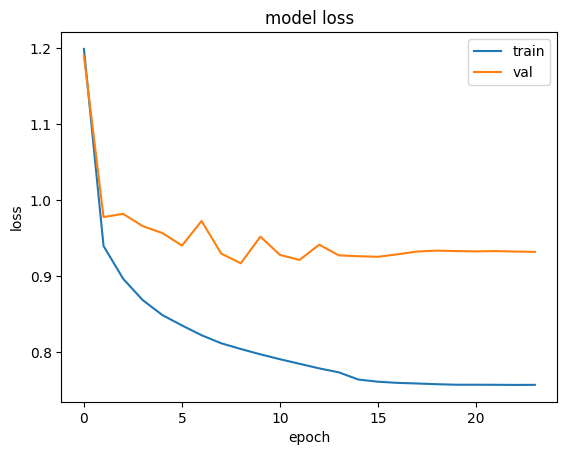

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Save the model

In [23]:
model.save(path_model/'unet_ICM')

INFO:tensorflow:Assets written to: unet_ICM\assets


### Load the model

In [19]:
model = tf.keras.models.load_model(path_model/'unet_ICM', custom_objects={'jaccard_index':jaccard_index, 'my_loss_fn':my_loss_fn})

### Evaluation (only the metric consider when training)

In [20]:
results = model.evaluate(x_test, y_test, batch_size=128)

1/1 [==============================] - 6s 6s/step - loss: 0.9094 - jaccard_index: 0.7898


## Evaluation

#### Predictions

In [21]:
predictions = model.predict(x_test)

#### Define the metrics

In [22]:
def accuracy(target, prediction):
    true_detec = np.logical_not(np.logical_xor(target, prediction))
    return np.sum(true_detec)/np.sum(np.ones_like(target))

def precision(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(prediction)

def recall(target, prediction):
    intersection = np.logical_and(target, prediction)
    return np.sum(intersection)/np.sum(target)

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def dice(target, prediction):
    intersection = np.logical_and(target, prediction)
    return 2*np.sum(intersection) / (np.sum(target) + np.sum(prediction))

In [23]:
def metrics(target, prediction):
    return {'accuracy': accuracy(target, prediction),
            'precision': precision(target, prediction),
            'recall': recall(target, prediction),
            'specificity': recall(1-target,1- prediction),
            'jaccard':jaccard(target, prediction),
            'dice': dice(target, prediction)}

In [24]:
def summary_metrics(y_test,predictions,thresh=0.5):
    a,p,r,s,j,d=0.,0.,0.,0.,0.,0.
    n=len(predictions)
    for i in range(n):
        preds= (predictions[i][:,:,0]>=thresh).astype('uint8')
        gt= y_test[i].astype('uint8')
        metricas=metrics(gt,preds)
        a+=metricas['accuracy']
        p+=metricas['precision']
        r+=metricas['recall']
        s+=metricas['specificity']
        j+=metricas['jaccard']
        d+=metricas['dice']
    return {'accuracy': a/n,
            'precision': p/n,
            'recall': r/n,
            'specificity': s/n,
            'jaccard':j/n,
            'dice': d/n}

### Metrics

In [25]:
summary_metrics(y_test,predictions, 0.5)

{'accuracy': 0.9798744603207237,
 'precision': 0.8843762620322737,
 'recall': 0.8844977853916165,
 'specificity': 0.9894385647599244,
 'jaccard': 0.7899223548240697,
 'dice': 0.874484430271296}

### INFERENCE
#### The whole set is needed to standarize the images.
This is a private dataset so it is not available.

In [26]:
path=Path('../IMAGES')
imgs, _ = load_imgs(path)
imgs,_,_ = std_norm(imgs)

In [27]:
predictions = model.predict(imgs,batch_size=2)

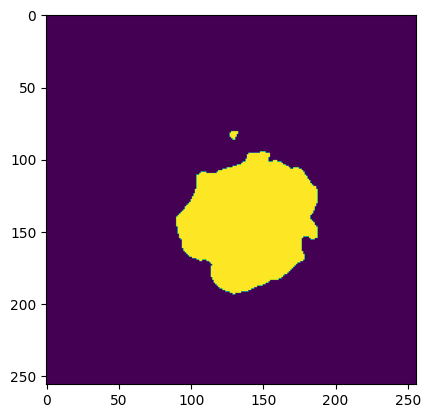

In [29]:
plt.imshow(predictions[0]>0.5)